Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1InFG9u6SJZJfUsEr6A-oqvvI_oZJl6d9'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1d32cwSV9lmpIxhBhSwtDo27GB9K3XQYb'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13867
Number of dev sentences:  2448
Number of test sentences:  27625
Number of words in the training dataset:  14450
Number of words in the dev dataset:  5242
Number of words in the test dataset:  21696
Tags in the training dataset: ['B-treatment', 'B-test', 'I-treatment', 'O', 'I-problem', 'I-test', 'B-problem']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['B-treatment', 'B-test', 'I-treatment', 'O', 'I-problem', 'I-test', 'B-problem']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['B-treatment', 'B-test', 'I-treatment', 'O', 'I-problem', 'I-test', 'B-problem']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 5851,0802338,O
1,Sentence: 15815,The,O
2,Sentence: 15815,visualized,O
3,Sentence: 15815,paranasal,O
4,Sentence: 15815,sinuses,O
5,Sentence: 15815,are,O
6,Sentence: 15815,clear,O
7,Sentence: 15815,.,O
8,Sentence: 4203,Chem-7,B-test
9,Sentence: 4203,:,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Admission', 'O'), ('Date', 'O'), (':', 'O')]

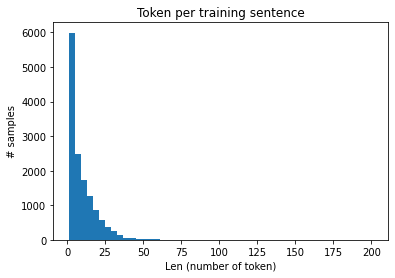

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

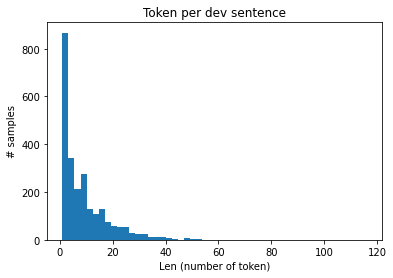

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

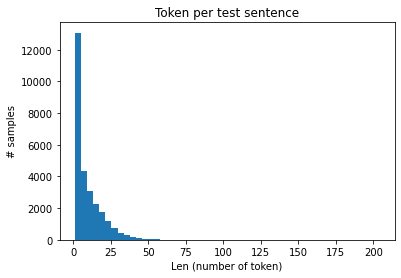

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

11207
clonazepam
0
I-problem


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
# X_train, y_train = random_remove_data_points(X_train, y_train, 0.95)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13867
Points in y_train before removal: 13867
Points in X_train before removal: 13867
Points in y_train before removal: 13867


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[26483, 24534]
[3, 3]
[2848, 10024, 5874, 20329, 6229, 11620, 6197, 4706, 18921, 17253, 6514, 26123]
[6, 4, 4, 4, 4, 4, 3, 1, 5, 5, 5, 3]
[20375, 18072, 6274]
[3, 3, 3]
11207
0
I-treatment
1.15
28388
7


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 13.7 MB/s 
     |████████████████████████████████| 6.6 MB 47.3 MB/s 
     |████████████████████████████████| 120 kB 69.9 MB/s 


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 747 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=dd1cf90b297ca26abb31d653b97f5c5b87be2d54707b562cb2519a9cabd6c9f0
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[26483, 24534]
[3, 3]
[2848, 10024, 5874, 20329, 6229, 11620, 6197, 4706, 18921, 17253, 6514, 26123]
[6, 4, 4, 4, 4, 4, 3, 1, 5, 5, 5, 3]
[20375, 18072, 6274]
[3, 3, 3]
11207
0
I-treatment
1.15
28388
7


In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 13867
Points in y_train after augmentation: 13867
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.076934814453125
Training loss per 100 training steps: 0.4080217381810198
Training loss per 100 training steps: 0.2951848675028898
Training loss per 100 training steps: 0.25808347234397233
Training loss per 100 training steps: 0.2313445507086572
Training loss epoch: 0.22421084201898991
Training accuracy epoch: 0.9288875228380907
Validating model...
Validation Loss: 0.1388280393870233
Validation Accuracy: 0.9556781442237189
Training epoch: 2
Training loss per 100 training steps: 0.11301907896995544
Training loss per 100 training steps: 0.08628076536230522
Training loss per 100 training steps: 0.08588689805671054
Training loss per 100 training steps: 0.08693183727092126
Training loss per 100 training steps: 0.08774499719186762
Training loss epoch: 0.08861855633368003
Training accuracy epoch: 0.9712695545908171
Validating model...
Validation Loss: 0.12945744876640958
Validation Accuracy: 0.9598433256726073
Training epoch: 3
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14138063228003578
Validation Accuracy: 0.9569631149239458
Validation duration: 3.252362416666665 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.3%
              precision    recall  f1-score   support

     problem       0.82      0.87      0.85     12546
        test       0.84      0.89      0.87      9012
   treatment       0.82      0.88      0.85      9297

   micro avg       0.83      0.88      0.85     30855
   macro avg       0.83      0.88      0.85     30855
weighted avg       0.83      0.88      0.85     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 13867
Points in y_train after augmentation: 13867
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8143049478530884
Training loss per 100 training steps: 0.37413781401839585
Training loss per 100 training steps: 0.28603435978664093
Training loss per 100 training steps: 0.2483358283053799
Training loss per 100 training steps: 0.22157397336719042
Training loss epoch: 0.21653434931201868
Training accuracy epoch: 0.9314346522752435
Validating model...
Validation Loss: 0.13457555362543502
Validation Accuracy: 0.9553875807426304
Training epoch: 2
Training loss per 100 training steps: 0.18992814421653748
Training loss per 100 training steps: 0.0974468673109123
Training loss per 100 training steps: 0.09419996528168074
Training loss per 100 training steps: 0.09075902505434331
Training loss per 100 training steps: 0.09120413413656843
Training loss epoch: 0.09178837652056379
Training accuracy epoch: 0.9703211201873695
Validating model...
Validation Loss: 0.1355926553392178
Validation Accuracy: 0.9586255929958234
Training epoch: 3
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14598278968845046
Validation Accuracy: 0.9521206848364311
Validation duration: 3.144779666666659 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.0%
              precision    recall  f1-score   support

     problem       0.81      0.83      0.82     12546
        test       0.83      0.84      0.84      9012
   treatment       0.82      0.85      0.84      9297

   micro avg       0.82      0.84      0.83     30855
   macro avg       0.82      0.84      0.83     30855
weighted avg       0.82      0.84      0.83     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 13867
Points in y_train after augmentation: 13867
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.06630802154541
Training loss per 100 training steps: 0.3874796669524495
Training loss per 100 training steps: 0.28382027080625444
Training loss per 100 training steps: 0.24392433255366314
Training loss per 100 training steps: 0.22086368218770347
Training loss epoch: 0.21499848911701808
Training accuracy epoch: 0.932651672177646
Validating model...
Validation Loss: 0.13589180103660403
Validation Accuracy: 0.9570357003504698
Training epoch: 2
Training loss per 100 training steps: 0.09892712533473969
Training loss per 100 training steps: 0.0874815386913643
Training loss per 100 training steps: 0.0918958594522147
Training loss per 100 training steps: 0.09044027827568724
Training loss per 100 training steps: 0.09001389425712408
Training loss epoch: 0.09015905640993593
Training accuracy epoch: 0.9708976956070456
Validating model...
Validation Loss: 0.13233992321924729
Validation Accuracy: 0.957347203672776
Training epoch: 3
Training l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14941491438636417
Validation Accuracy: 0.9528198172058301
Validation duration: 3.1389994999999997 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.4%
              precision    recall  f1-score   support

     problem       0.83      0.87      0.85     12546
        test       0.84      0.87      0.85      9012
   treatment       0.81      0.84      0.82      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 13867
Points in y_train after augmentation: 13867
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.102623462677002
Training loss per 100 training steps: 0.38928973202658174
Training loss per 100 training steps: 0.29208727169837523
Training loss per 100 training steps: 0.25271550643929214
Training loss per 100 training steps: 0.22913776611226455
Training loss epoch: 0.2225197082737349
Training accuracy epoch: 0.9298474829802353
Validating model...
Validation Loss: 0.13276134337020384
Validation Accuracy: 0.9564774638445911
Training epoch: 2
Training loss per 100 training steps: 0.14430181682109833
Training loss per 100 training steps: 0.09075547741855135
Training loss per 100 training steps: 0.09050559890526
Training loss per 100 training steps: 0.09178678668181464
Training loss per 100 training steps: 0.09168092386002775
Training loss epoch: 0.09183380792071949
Training accuracy epoch: 0.9703141839325929
Validating model...
Validation Loss: 0.12935120322100527
Validation Accuracy: 0.9593036935451575
Training epoch: 3
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14688368227776932
Validation Accuracy: 0.9536429258651627


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.12587443333332 minutes
F1-score (test): 84.0%
              precision    recall  f1-score   support

     problem       0.79      0.88      0.83     12546
        test       0.82      0.88      0.85      9012
   treatment       0.82      0.87      0.84      9297

   micro avg       0.81      0.88      0.84     30855
   macro avg       0.81      0.88      0.84     30855
weighted avg       0.81      0.88      0.84     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 13867
Points in y_train after augmentation: 13867
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2285525798797607
Training loss per 100 training steps: 0.3873993071294067
Training loss per 100 training steps: 0.28745311841516946
Training loss per 100 training steps: 0.25036500811428325
Training loss per 100 training steps: 0.22292677850051415
Training loss epoch: 0.21860836529546343
Training accuracy epoch: 0.9314571698155706
Validating model...
Validation Loss: 0.13938939116604918
Validation Accuracy: 0.9546328689276871
Training epoch: 2
Training loss per 100 training steps: 0.08777526021003723
Training loss per 100 training steps: 0.09452362558666137
Training loss per 100 training steps: 0.09869803055954068
Training loss per 100 training steps: 0.10220699071995543
Training loss per 100 training steps: 0.09985282322963203
Training loss epoch: 0.0989146226274562
Training accuracy epoch: 0.9682542506897998
Validating model...
Validation Loss: 0.12688752672598733
Validation Accuracy: 0.9607682072053384
Training epoch: 3
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1537106890270176
Validation Accuracy: 0.9551800258874441
Validation duration: 3.127663916666673 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.4%
              precision    recall  f1-score   support

     problem       0.84      0.86      0.85     12546
        test       0.84      0.89      0.87      9012
   treatment       0.82      0.87      0.84      9297

   micro avg       0.83      0.87      0.85     30855
   macro avg       0.83      0.88      0.85     30855
weighted avg       0.83      0.87      0.85     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 13867
Points in y_train after augmentation: 13867
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.973937749862671
Training loss per 100 training steps: 0.3897660719138561
Training loss per 100 training steps: 0.29490352711125983
Training loss per 100 training steps: 0.24857329394037145
Training loss per 100 training steps: 0.2237313110613615
Training loss epoch: 0.21955173390097746
Training accuracy epoch: 0.9302220028496948
Validating model...
Validation Loss: 0.13299755329967705
Validation Accuracy: 0.9563139802462095
Training epoch: 2
Training loss per 100 training steps: 0.0515083484351635
Training loss per 100 training steps: 0.08164166607479058
Training loss per 100 training steps: 0.08782705190864887
Training loss per 100 training steps: 0.08933932172208776
Training loss per 100 training steps: 0.08899400379401899
Training loss epoch: 0.08835121379276815
Training accuracy epoch: 0.9721737036474309
Validating model...
Validation Loss: 0.13802187014129255
Validation Accuracy: 0.9572012897606599
Training epoch: 3
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14091209392710072
Validation Accuracy: 0.9543794992535086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.125490816666661 minutes
F1-score (test): 84.2%
              precision    recall  f1-score   support

     problem       0.82      0.84      0.83     12546
        test       0.83      0.89      0.86      9012
   treatment       0.84      0.84      0.84      9297

   micro avg       0.83      0.86      0.84     30855
   macro avg       0.83      0.86      0.84     30855
weighted avg       0.83      0.86      0.84     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 13867
Points in y_train after augmentation: 13867
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.6050825119018555
Training loss per 100 training steps: 0.4297834432656222
Training loss per 100 training steps: 0.31415602702888384
Training loss per 100 training steps: 0.26566370118075233
Training loss per 100 training steps: 0.23633417874073
Training loss epoch: 0.23034838750563597
Training accuracy epoch: 0.9281541348656105
Validating model...
Validation Loss: 0.14131459617963085
Validation Accuracy: 0.9559687110464874
Training epoch: 2
Training loss per 100 training steps: 0.2347610890865326
Training loss per 100 training steps: 0.09574634406604979
Training loss per 100 training steps: 0.09518489913449656
Training loss per 100 training steps: 0.09519721602284631
Training loss per 100 training steps: 0.0958907101303339
Training loss epoch: 0.09509303697925661
Training accuracy epoch: 0.9697314062386214
Validating model...
Validation Loss: 0.14251800512822418
Validation Accuracy: 0.9604786354608336
Training epoch: 3
Training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14358686662011746
Validation Accuracy: 0.9553179616360821
Validation duration: 3.1274540500000207 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.7%
              precision    recall  f1-score   support

     problem       0.84      0.83      0.83     12546
        test       0.80      0.85      0.83      9012
   treatment       0.87      0.84      0.85      9297

   micro avg       0.84      0.84      0.84     30855
   macro avg       0.84      0.84      0.84     30855
weighted avg       0.84      0.84      0.84     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 13867
Points in y_train after augmentation: 13867
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7298275232315063
Training loss per 100 training steps: 0.3798373255251658
Training loss per 100 training steps: 0.2764290312851839
Training loss per 100 training steps: 0.2419596537081308
Training loss per 100 training steps: 0.22208987145761303
Training loss epoch: 0.21660299896163873
Training accuracy epoch: 0.9311025849343629
Validating model...
Validation Loss: 0.14293226679520948
Validation Accuracy: 0.9533801540938055
Training epoch: 2
Training loss per 100 training steps: 0.04738463833928108
Training loss per 100 training steps: 0.08779536662992127
Training loss per 100 training steps: 0.0844905780632957
Training loss per 100 training steps: 0.08744158803259465
Training loss per 100 training steps: 0.08931226506852487
Training loss epoch: 0.08981154420121235
Training accuracy epoch: 0.9711434610330614
Validating model...
Validation Loss: 0.12930076540290536
Validation Accuracy: 0.9609076757196967
Training epoch: 3
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13871456233189544
Validation Accuracy: 0.9573101544344467
Validation duration: 3.1272170000000186 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.6%
              precision    recall  f1-score   support

     problem       0.83      0.88      0.86     12546
        test       0.85      0.86      0.86      9012
   treatment       0.85      0.86      0.86      9297

   micro avg       0.85      0.87      0.86     30855
   macro avg       0.85      0.87      0.86     30855
weighted avg       0.85      0.87      0.86     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 13867
Points in y_train after augmentation: 13867
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4036762714385986
Training loss per 100 training steps: 0.43058609837057565
Training loss per 100 training steps: 0.3148356346941706
Training loss per 100 training steps: 0.2655840052718736
Training loss per 100 training steps: 0.2384346826303927
Training loss epoch: 0.23309644409519736
Training accuracy epoch: 0.925966111577446
Validating model...
Validation Loss: 0.13416168103357415
Validation Accuracy: 0.9558855484718062
Training epoch: 2
Training loss per 100 training steps: 0.09708733856678009
Training loss per 100 training steps: 0.0917767636883672
Training loss per 100 training steps: 0.0931599054355823
Training loss per 100 training steps: 0.0959946013912806
Training loss per 100 training steps: 0.09843073467586998
Training loss epoch: 0.0974213495198208
Training accuracy epoch: 0.9682048822287194
Validating model...
Validation Loss: 0.1416319382751917
Validation Accuracy: 0.9573427188638832
Training epoch: 3
Training los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14065284708825251
Validation Accuracy: 0.9542993186795471


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1309052166666635 minutes
F1-score (test): 84.3%
              precision    recall  f1-score   support

     problem       0.84      0.83      0.84     12546
        test       0.82      0.89      0.85      9012
   treatment       0.84      0.84      0.84      9297

   micro avg       0.83      0.85      0.84     30855
   macro avg       0.83      0.86      0.84     30855
weighted avg       0.83      0.85      0.84     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 13867
Points in y_train after augmentation: 13867
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1263368129730225
Training loss per 100 training steps: 0.4012833702387196
Training loss per 100 training steps: 0.2966544816075866
Training loss per 100 training steps: 0.25272294382666827
Training loss per 100 training steps: 0.22624474801030242
Training loss epoch: 0.22091473080217838
Training accuracy epoch: 0.9297480212240524
Validating model...
Validation Loss: 0.12482300579741404
Validation Accuracy: 0.9597538504673202
Training epoch: 2
Training loss per 100 training steps: 0.06116035208106041
Training loss per 100 training steps: 0.08801792373899187
Training loss per 100 training steps: 0.08800198915252341
Training loss per 100 training steps: 0.08773318050658188
Training loss per 100 training steps: 0.08791331206901264
Training loss epoch: 0.08864978062255043
Training accuracy epoch: 0.9712182478272289
Validating model...
Validation Loss: 0.12517240300000487
Validation Accuracy: 0.9586320453031919
Training epoch: 3
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1432377098697341
Validation Accuracy: 0.9537730481857639
Validation duration: 3.130216566666665 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.0%
              precision    recall  f1-score   support

     problem       0.82      0.87      0.85     12546
        test       0.87      0.87      0.87      9012
   treatment       0.78      0.88      0.83      9297

   micro avg       0.82      0.88      0.85     30855
   macro avg       0.83      0.88      0.85     30855
weighted avg       0.83      0.88      0.85     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.005070447921753
Training loss per 100 training steps: 0.3908421085907681
Training loss per 100 training steps: 0.2987817872445382
Training loss per 100 training steps: 0.25533125481484736
Training loss per 100 training steps: 0.23252067196547538
Training loss per 100 training steps: 0.21544344907630228
Training loss epoch: 0.2102179059421994
Training accuracy epoch: 0.9327923753346463
Validating model...
Validation Loss: 0.13639844519799793
Validation Accuracy: 0.956424719964669
Training epoch: 2
Training loss per 100 training steps: 0.100233294069767
Training loss per 100 training steps: 0.08337432946917592
Training loss per 100 training steps: 0.09040407958991863
Training loss per 100 training steps: 0.09194432709681681
Training loss per 100 training steps: 0.09313949383446886
Training loss per 100 training steps: 0.09256132161467821
Training loss epoch: 0.09256557064436761
Training accuracy epoch: 0.9706408872147098
Validatin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14563924031810732
Validation Accuracy: 0.9556599201460708
Validation duration: 3.1208764833333285 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.4%
              precision    recall  f1-score   support

     problem       0.81      0.86      0.84     12546
        test       0.83      0.89      0.86      9012
   treatment       0.81      0.88      0.84      9297

   micro avg       0.82      0.87      0.84     30855
   macro avg       0.82      0.88      0.85     30855
weighted avg       0.82      0.87      0.84     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.005798101425171
Training loss per 100 training steps: 0.39815102429083077
Training loss per 100 training steps: 0.2948392204458441
Training loss per 100 training steps: 0.2509693363526731
Training loss per 100 training steps: 0.22755043762283134
Training loss per 100 training steps: 0.21433486827387066
Training loss epoch: 0.20950509120823602
Training accuracy epoch: 0.9341743841045647
Validating model...
Validation Loss: 0.1441662750364124
Validation Accuracy: 0.9525762241642008
Training epoch: 2
Training loss per 100 training steps: 0.1541123241186142
Training loss per 100 training steps: 0.08647190201289878
Training loss per 100 training steps: 0.08852030326199917
Training loss per 100 training steps: 0.09046506449468805
Training loss per 100 training steps: 0.08897571122166968
Training loss per 100 training steps: 0.08934552545385982
Training loss epoch: 0.09015326338864836
Training accuracy epoch: 0.9708954935615561
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15187195129153594
Validation Accuracy: 0.9519912669904955
Validation duration: 3.1299746666666883 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.8%
              precision    recall  f1-score   support

     problem       0.81      0.84      0.83     12546
        test       0.80      0.90      0.85      9012
   treatment       0.84      0.85      0.84      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.284592628479004
Training loss per 100 training steps: 0.42173181267658083
Training loss per 100 training steps: 0.30737891040779464
Training loss per 100 training steps: 0.26293351319293645
Training loss per 100 training steps: 0.23499755579002776
Training loss per 100 training steps: 0.21639090651895354
Training loss epoch: 0.2120181765592901
Training accuracy epoch: 0.9329014150505417
Validating model...
Validation Loss: 0.15001367695339315
Validation Accuracy: 0.9509544634936853
Training epoch: 2
Training loss per 100 training steps: 0.08683957904577255
Training loss per 100 training steps: 0.08802129462877713
Training loss per 100 training steps: 0.0859988742225354
Training loss per 100 training steps: 0.08485790677492405
Training loss per 100 training steps: 0.08580225901190479
Training loss per 100 training steps: 0.08707434485876513
Training loss epoch: 0.08671406427968802
Training accuracy epoch: 0.9727825921977659
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14905992067522472
Validation Accuracy: 0.9561302797554726


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1939892833333334 minutes
F1-score (test): 84.5%
              precision    recall  f1-score   support

     problem       0.84      0.86      0.85     12546
        test       0.82      0.87      0.84      9012
   treatment       0.86      0.82      0.84      9297

   micro avg       0.84      0.85      0.84     30855
   macro avg       0.84      0.85      0.84     30855
weighted avg       0.84      0.85      0.84     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1680617332458496
Training loss per 100 training steps: 0.4058717960989711
Training loss per 100 training steps: 0.30555363145856124
Training loss per 100 training steps: 0.25742491991862504
Training loss per 100 training steps: 0.23204895310995732
Training loss per 100 training steps: 0.2164115094488669
Training loss epoch: 0.2104827531225072
Training accuracy epoch: 0.9328616465816367
Validating model...
Validation Loss: 0.131404922646168
Validation Accuracy: 0.9565713949760903
Training epoch: 2
Training loss per 100 training steps: 0.07860174030065536
Training loss per 100 training steps: 0.09151059296904224
Training loss per 100 training steps: 0.09128492878314423
Training loss per 100 training steps: 0.08942369380625478
Training loss per 100 training steps: 0.08732228329001074
Training loss per 100 training steps: 0.0875152817977492
Training loss epoch: 0.08829027166370151
Training accuracy epoch: 0.9717449303186065
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14197140631235758
Validation Accuracy: 0.956052108166547
Validation duration: 3.1998701833333447 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.7%
              precision    recall  f1-score   support

     problem       0.83      0.86      0.84     12546
        test       0.86      0.85      0.85      9012
   treatment       0.84      0.86      0.85      9298

   micro avg       0.84      0.86      0.85     30856
   macro avg       0.84      0.86      0.85     30856
weighted avg       0.84      0.86      0.85     30856

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.942955493927002
Training loss per 100 training steps: 0.4183439275268281
Training loss per 100 training steps: 0.31517694844164656
Training loss per 100 training steps: 0.2668024537051437
Training loss per 100 training steps: 0.24077195014590932
Training loss per 100 training steps: 0.22209159507157797
Training loss epoch: 0.2163450491521851
Training accuracy epoch: 0.9312621124185828
Validating model...
Validation Loss: 0.13187801806473887
Validation Accuracy: 0.9578596164905157
Training epoch: 2
Training loss per 100 training steps: 0.19472305476665497
Training loss per 100 training steps: 0.08569603151466587
Training loss per 100 training steps: 0.08565198538352305
Training loss per 100 training steps: 0.08841113797528205
Training loss per 100 training steps: 0.09126940252319758
Training loss per 100 training steps: 0.09086813233577146
Training loss epoch: 0.09349424439238391
Training accuracy epoch: 0.9703618013236177
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1465787732029437
Validation Accuracy: 0.9542020246394803
Validation duration: 3.12436556666665 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.4%
              precision    recall  f1-score   support

     problem       0.81      0.87      0.84     12546
        test       0.77      0.87      0.82      9012
   treatment       0.83      0.85      0.84      9297

   micro avg       0.81      0.87      0.83     30855
   macro avg       0.81      0.86      0.83     30855
weighted avg       0.81      0.87      0.83     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9499709606170654
Training loss per 100 training steps: 0.39656466599738244
Training loss per 100 training steps: 0.30016282860615956
Training loss per 100 training steps: 0.2553576618754784
Training loss per 100 training steps: 0.23284858917617737
Training loss per 100 training steps: 0.21426812040353727
Training loss epoch: 0.20936878514218374
Training accuracy epoch: 0.9338155006667432
Validating model...
Validation Loss: 0.13414861653725824
Validation Accuracy: 0.9573638508126012
Training epoch: 2
Training loss per 100 training steps: 0.06915400177240372
Training loss per 100 training steps: 0.08383165968416056
Training loss per 100 training steps: 0.08817869602280914
Training loss per 100 training steps: 0.08799708568091903
Training loss per 100 training steps: 0.08709368225595823
Training loss per 100 training steps: 0.08846946144866907
Training loss epoch: 0.08861941539053547
Training accuracy epoch: 0.9717622680171154
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14380865882978672
Validation Accuracy: 0.9547431615070789
Validation duration: 3.1122268999999507 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.8%
              precision    recall  f1-score   support

     problem       0.81      0.84      0.83     12546
        test       0.86      0.86      0.86      9012
   treatment       0.80      0.87      0.83      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9329174757003784
Training loss per 100 training steps: 0.4110368600871303
Training loss per 100 training steps: 0.3073015048432706
Training loss per 100 training steps: 0.260645033587451
Training loss per 100 training steps: 0.2353077981147237
Training loss per 100 training steps: 0.21914579083551905
Training loss epoch: 0.2132368974964997
Training accuracy epoch: 0.9328285053118989
Validating model...
Validation Loss: 0.13042322593414551
Validation Accuracy: 0.9582417554217912
Training epoch: 2
Training loss per 100 training steps: 0.07557377219200134
Training loss per 100 training steps: 0.08478713058636035
Training loss per 100 training steps: 0.0877596595097537
Training loss per 100 training steps: 0.0879534566341791
Training loss per 100 training steps: 0.09092736324792416
Training loss per 100 training steps: 0.09324721006412587
Training loss epoch: 0.09239327048752251
Training accuracy epoch: 0.9706217687836768
Validating

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14611213482351526
Validation Accuracy: 0.9540153098586658


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1896941666667167 minutes
F1-score (test): 84.0%
              precision    recall  f1-score   support

     problem       0.81      0.86      0.83     12546
        test       0.84      0.86      0.85      9012
   treatment       0.82      0.86      0.84      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.086076259613037
Training loss per 100 training steps: 0.391824540082771
Training loss per 100 training steps: 0.29049698986224276
Training loss per 100 training steps: 0.2453868005399985
Training loss per 100 training steps: 0.22464431033578894
Training loss per 100 training steps: 0.2109385154724954
Training loss epoch: 0.20556310016483179
Training accuracy epoch: 0.9343510287784229
Validating model...
Validation Loss: 0.13870571989130664
Validation Accuracy: 0.9545883665766529
Training epoch: 2
Training loss per 100 training steps: 0.1377454251050949
Training loss per 100 training steps: 0.0924327862218465
Training loss per 100 training steps: 0.08878688331211533
Training loss per 100 training steps: 0.08861021134705342
Training loss per 100 training steps: 0.08889285507298393
Training loss per 100 training steps: 0.08854668742294856
Training loss epoch: 0.08907790965060411
Training accuracy epoch: 0.9713752830984984
Validatin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14363726225349605
Validation Accuracy: 0.9557181406916302
Validation duration: 3.11930718333327 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.0%
              precision    recall  f1-score   support

     problem       0.84      0.87      0.85     12546
        test       0.85      0.82      0.83      9012
   treatment       0.85      0.86      0.86      9297

   micro avg       0.85      0.85      0.85     30855
   macro avg       0.85      0.85      0.85     30855
weighted avg       0.85      0.85      0.85     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8849895000457764
Training loss per 100 training steps: 0.40151126660627895
Training loss per 100 training steps: 0.3017405240764072
Training loss per 100 training steps: 0.26196676670910907
Training loss per 100 training steps: 0.23400242676368527
Training loss per 100 training steps: 0.2180090361347277
Training loss epoch: 0.21320197902056234
Training accuracy epoch: 0.9328484716892403
Validating model...
Validation Loss: 0.13233728876168077
Validation Accuracy: 0.9570496441864292
Training epoch: 2
Training loss per 100 training steps: 0.06309506297111511
Training loss per 100 training steps: 0.09271882456902525
Training loss per 100 training steps: 0.0868805198795834
Training loss per 100 training steps: 0.08688474301112649
Training loss per 100 training steps: 0.0871951462482648
Training loss per 100 training steps: 0.0871827942737473
Training loss epoch: 0.08785621043658949
Training accuracy epoch: 0.9714709720260039
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14479802762313435
Validation Accuracy: 0.9547439435255418
Validation duration: 3.1199287166666183 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.9%
              precision    recall  f1-score   support

     problem       0.80      0.88      0.84     12546
        test       0.81      0.86      0.84      9012
   treatment       0.83      0.86      0.85      9297

   micro avg       0.81      0.87      0.84     30855
   macro avg       0.81      0.87      0.84     30855
weighted avg       0.81      0.87      0.84     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 17334
Points in y_train after augmentation: 17334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8637526035308838
Training loss per 100 training steps: 0.41101102944057766
Training loss per 100 training steps: 0.3002870024659147
Training loss per 100 training steps: 0.2600606785486901
Training loss per 100 training steps: 0.2346280927577072
Training loss per 100 training steps: 0.21719203745117208
Training loss epoch: 0.21053984366714734
Training accuracy epoch: 0.9340107577246436
Validating model...
Validation Loss: 0.1403157225773706
Validation Accuracy: 0.9546752847484782
Training epoch: 2
Training loss per 100 training steps: 0.11088825017213821
Training loss per 100 training steps: 0.090577771186386
Training loss per 100 training steps: 0.0888351076908076
Training loss per 100 training steps: 0.0894554516430511
Training loss per 100 training steps: 0.09005473258247845
Training loss per 100 training steps: 0.09014392232972229
Training loss epoch: 0.08984446525917392
Training accuracy epoch: 0.9707851419463813
Validating

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.149387624984094
Validation Accuracy: 0.9552635062678329
Validation duration: 3.119838833333294 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.5%
              precision    recall  f1-score   support

     problem       0.83      0.86      0.84     12546
        test       0.82      0.88      0.85      9012
   treatment       0.84      0.84      0.84      9297

   micro avg       0.83      0.86      0.85     30855
   macro avg       0.83      0.86      0.85     30855
weighted avg       0.83      0.86      0.85     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0372326374053955
Training loss per 100 training steps: 0.39656256817945157
Training loss per 100 training steps: 0.29604987972485486
Training loss per 100 training steps: 0.25289761000297395
Training loss per 100 training steps: 0.22806702818990943
Training loss per 100 training steps: 0.2132746507962069
Training loss per 100 training steps: 0.20099598836593838
Training loss epoch: 0.19670884464291596
Training accuracy epoch: 0.93742750918056
Validating model...
Validation Loss: 0.13691921798246248
Validation Accuracy: 0.9563812081053255
Training epoch: 2
Training loss per 100 training steps: 0.08501828461885452
Training loss per 100 training steps: 0.08418318107355349
Stopping epoch...
Training loss epoch: 0.08418318107355349
Training accuracy epoch: 0.9634045193944282
Validating model...
Validation Loss: 0.1502517242976404
Validation Accuracy: 0.9544271713290252
Training epoch: 3
Training loss per 100 training steps: 0.0693750

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1537430761187958
Validation Accuracy: 0.9526142775595339
Validation duration: 3.132384383333313 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.4%
              precision    recall  f1-score   support

     problem       0.83      0.81      0.82     12546
        test       0.76      0.87      0.81      9012
   treatment       0.83      0.86      0.84      9297

   micro avg       0.81      0.84      0.82     30855
   macro avg       0.81      0.85      0.82     30855
weighted avg       0.81      0.84      0.82     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.177449941635132
Training loss per 100 training steps: 0.39328051646157064
Training loss per 100 training steps: 0.29525333483569066
Training loss per 100 training steps: 0.2539174011428887
Training loss per 100 training steps: 0.22944851952635142
Training loss per 100 training steps: 0.21462323437045197
Training loss per 100 training steps: 0.20217277912946788
Training loss epoch: 0.19770428299125622
Training accuracy epoch: 0.9374455571285478
Validating model...
Validation Loss: 0.139334061751505
Validation Accuracy: 0.9539717182150457
Training epoch: 2
Training loss per 100 training steps: 0.08727484196424484
Training loss per 100 training steps: 0.07879812563631204
Training loss per 100 training steps: 0.07726074302967507
Training loss per 100 training steps: 0.08127337706699175
Training loss per 100 training steps: 0.08201379684192545
Training loss per 100 training steps: 0.08265968294490776
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14817760030726074
Validation Accuracy: 0.9521604846968785
Validation duration: 3.1185691499998938 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.0%
              precision    recall  f1-score   support

     problem       0.83      0.81      0.82     12546
        test       0.82      0.86      0.84      9012
   treatment       0.80      0.87      0.83      9297

   micro avg       0.82      0.84      0.83     30855
   macro avg       0.82      0.85      0.83     30855
weighted avg       0.82      0.84      0.83     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2025249004364014
Training loss per 100 training steps: 0.38770187166657777
Training loss per 100 training steps: 0.29334605885530585
Training loss per 100 training steps: 0.24959429270553826
Training loss per 100 training steps: 0.22807591795884166
Training loss per 100 training steps: 0.21275554055314577
Training loss per 100 training steps: 0.20019856439949868
Training loss epoch: 0.19598339379016888
Training accuracy epoch: 0.9380374992124312
Validating model...
Validation Loss: 0.13939411376977895
Validation Accuracy: 0.9552886045649642
Training epoch: 2
Training loss per 100 training steps: 0.052192606031894684
Training loss per 100 training steps: 0.07710499585707589
Training loss per 100 training steps: 0.07749619511470421
Training loss per 100 training steps: 0.07745094139104171
Training loss per 100 training steps: 0.07913025209629104
Training loss per 100 training steps: 0.07818545889622437
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14764976979414415
Validation Accuracy: 0.953284932815452


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.191627316666563 minutes
F1-score (test): 83.8%
              precision    recall  f1-score   support

     problem       0.83      0.84      0.84     12546
        test       0.84      0.87      0.85      9012
   treatment       0.81      0.85      0.83      9298

   micro avg       0.83      0.85      0.84     30856
   macro avg       0.83      0.85      0.84     30856
weighted avg       0.83      0.85      0.84     30856

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.103853702545166
Training loss per 100 training steps: 0.3968939683077359
Training loss per 100 training steps: 0.30106717753988593
Training loss per 100 training steps: 0.2592821892511805
Training loss per 100 training steps: 0.23352101918059098
Training loss per 100 training steps: 0.21675782962265366
Training loss per 100 training steps: 0.20477671520211138
Training loss epoch: 0.19870349636928003
Training accuracy epoch: 0.9364517789803108
Validating model...
Validation Loss: 0.13932210656923133
Validation Accuracy: 0.9567486408096826
Training epoch: 2
Training loss per 100 training steps: 0.10231153666973114
Training loss per 100 training steps: 0.07701071986172459
Training loss per 100 training steps: 0.07926974490062515
Training loss per 100 training steps: 0.07981344859465413
Training loss per 100 training steps: 0.08161309360296574
Training loss per 100 training steps: 0.08055162105426758
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1554743057090996
Validation Accuracy: 0.9534168916048971
Validation duration: 3.1209604833333286 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.3%
              precision    recall  f1-score   support

     problem       0.81      0.86      0.83     12546
        test       0.84      0.87      0.85      9012
   treatment       0.83      0.86      0.85      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0688600540161133
Training loss per 100 training steps: 0.40992669097267753
Training loss per 100 training steps: 0.31546525868462094
Training loss per 100 training steps: 0.2685518115016313
Training loss per 100 training steps: 0.2394637105861061
Training loss per 100 training steps: 0.21755369172474284
Training loss per 100 training steps: 0.20676417054822313
Training loss epoch: 0.20067574406978309
Training accuracy epoch: 0.9366723329285217
Validating model...
Validation Loss: 0.14411925120496905
Validation Accuracy: 0.9524221379943514
Training epoch: 2
Training loss per 100 training steps: 0.17149588465690613
Training loss per 100 training steps: 0.09305436224077303
Training loss per 100 training steps: 0.08675134062896765
Training loss per 100 training steps: 0.08672573819966907
Training loss per 100 training steps: 0.0878542497582232
Training loss per 100 training steps: 0.08771364819890487
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15369321178769935
Validation Accuracy: 0.9554172117883512
Validation duration: 3.1191551666666784 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.4%
              precision    recall  f1-score   support

     problem       0.83      0.85      0.84     12546
        test       0.84      0.84      0.84      9012
   treatment       0.83      0.87      0.85      9297

   micro avg       0.83      0.86      0.84     30855
   macro avg       0.83      0.86      0.84     30855
weighted avg       0.83      0.86      0.84     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.684262990951538
Training loss per 100 training steps: 0.3713156041679996
Training loss per 100 training steps: 0.2902640110965985
Training loss per 100 training steps: 0.2503268397304901
Training loss per 100 training steps: 0.2272015057058257
Training loss per 100 training steps: 0.2124214571586507
Training loss per 100 training steps: 0.2004904180343655
Training loss epoch: 0.19701271226626754
Training accuracy epoch: 0.9373611248932994
Validating model...
Validation Loss: 0.13753708669698084
Validation Accuracy: 0.9550659768522999
Training epoch: 2
Training loss per 100 training steps: 0.060140907764434814
Training loss per 100 training steps: 0.08390822600905258
Training loss per 100 training steps: 0.08498058366630949
Training loss per 100 training steps: 0.0854566764315448
Training loss per 100 training steps: 0.08444273105806246
Training loss per 100 training steps: 0.08759284341064637
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14633211671618349
Validation Accuracy: 0.9581453787398642
Validation duration: 3.1446583999999955 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.4%
              precision    recall  f1-score   support

     problem       0.83      0.87      0.85     12546
        test       0.84      0.88      0.86      9012
   treatment       0.84      0.87      0.85      9297

   micro avg       0.84      0.87      0.85     30855
   macro avg       0.84      0.87      0.85     30855
weighted avg       0.84      0.87      0.85     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0665156841278076
Training loss per 100 training steps: 0.3955092245325594
Training loss per 100 training steps: 0.2998184721861313
Training loss per 100 training steps: 0.2570574754026047
Training loss per 100 training steps: 0.23144797409450324
Training loss per 100 training steps: 0.21391877332728304
Training loss per 100 training steps: 0.2013550149447311
Training loss epoch: 0.19606415925836462
Training accuracy epoch: 0.9379707392713024
Validating model...
Validation Loss: 0.14120524971709622
Validation Accuracy: 0.9539374174757209
Training epoch: 2
Training loss per 100 training steps: 0.09290634095668793
Training loss per 100 training steps: 0.07685347989496619
Training loss per 100 training steps: 0.07921820928560412
Training loss per 100 training steps: 0.08266250494607659
Training loss per 100 training steps: 0.0819715041820508
Training loss per 100 training steps: 0.08221671318527526
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14859687397903246
Validation Accuracy: 0.9535725377599514


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1212255666665443 minutes
F1-score (test): 83.6%
              precision    recall  f1-score   support

     problem       0.83      0.82      0.83     12546
        test       0.83      0.85      0.84      9012
   treatment       0.85      0.84      0.85      9297

   micro avg       0.84      0.83      0.84     30855
   macro avg       0.84      0.83      0.84     30855
weighted avg       0.84      0.83      0.84     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1724138259887695
Training loss per 100 training steps: 0.4191968671166071
Training loss per 100 training steps: 0.31006932684882954
Training loss per 100 training steps: 0.26399666057324095
Training loss per 100 training steps: 0.23647350563372757
Training loss per 100 training steps: 0.21919774501296335
Training loss per 100 training steps: 0.20397835349146518
Training loss epoch: 0.19799312840821365
Training accuracy epoch: 0.937152406479441
Validating model...
Validation Loss: 0.13984077963252345
Validation Accuracy: 0.9541937378994831
Training epoch: 2
Training loss per 100 training steps: 0.07968904078006744
Training loss per 100 training steps: 0.08066484131988617
Training loss per 100 training steps: 0.08409806765819812
Training loss per 100 training steps: 0.08451889977911085
Training loss per 100 training steps: 0.08331760487976737
Training loss per 100 training steps: 0.08216612305336013
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14852375304326415
Validation Accuracy: 0.952623711214298
Validation duration: 3.114567666666699 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.6%
              precision    recall  f1-score   support

     problem       0.84      0.82      0.83     12546
        test       0.83      0.85      0.84      9012
   treatment       0.83      0.86      0.84      9297

   micro avg       0.83      0.84      0.84     30855
   macro avg       0.83      0.84      0.84     30855
weighted avg       0.83      0.84      0.84     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.400984525680542
Training loss per 100 training steps: 0.3950181482451977
Training loss per 100 training steps: 0.3031724878952871
Training loss per 100 training steps: 0.26037711866719776
Training loss per 100 training steps: 0.23443766573718064
Training loss per 100 training steps: 0.21656325208153315
Training loss per 100 training steps: 0.2044392875310486
Training loss epoch: 0.19866680166345754
Training accuracy epoch: 0.9370785716737148
Validating model...
Validation Loss: 0.13186535396455945
Validation Accuracy: 0.9576550068391617
Training epoch: 2
Training loss per 100 training steps: 0.06661521643400192
Training loss per 100 training steps: 0.08338933243499239
Training loss per 100 training steps: 0.08313157777788478
Training loss per 100 training steps: 0.08373178324454844
Training loss per 100 training steps: 0.08467625752044958
Training loss per 100 training steps: 0.08485460745174431
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1456892609507863
Validation Accuracy: 0.9539659870224612
Validation duration: 3.1396683666668346 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.7%
              precision    recall  f1-score   support

     problem       0.83      0.82      0.82     12546
        test       0.83      0.88      0.85      9012
   treatment       0.83      0.86      0.84      9297

   micro avg       0.83      0.85      0.84     30855
   macro avg       0.83      0.85      0.84     30855
weighted avg       0.83      0.85      0.84     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 20801
Points in y_train after augmentation: 20801
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3730525970458984
Training loss per 100 training steps: 0.40096137975112045
Training loss per 100 training steps: 0.2949830526995718
Training loss per 100 training steps: 0.25333570916688325
Training loss per 100 training steps: 0.23060346226628284
Training loss per 100 training steps: 0.2144672490448176
Training loss per 100 training steps: 0.20241485696949202
Training loss epoch: 0.19727134174122238
Training accuracy epoch: 0.9373124958000522
Validating model...
Validation Loss: 0.1334257409847402
Validation Accuracy: 0.9560612018816432
Training epoch: 2
Training loss per 100 training steps: 0.06956884264945984
Training loss per 100 training steps: 0.07026893212137246
Stopping epoch...
Training loss epoch: 0.07026893212137246
Training accuracy epoch: 0.9677344340257115
Validating model...
Validation Loss: 0.14532391325413407
Validation Accuracy: 0.9575644386114384
Training epoch: 3
Training loss per 100 training steps: 0.086940

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14362680347187928
Validation Accuracy: 0.9548736513115592
Validation duration: 3.106869000000006 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.3%
              precision    recall  f1-score   support

     problem       0.81      0.86      0.83     12546
        test       0.84      0.89      0.86      9012
   treatment       0.85      0.82      0.84      9297

   micro avg       0.83      0.86      0.84     30855
   macro avg       0.83      0.86      0.84     30855
weighted avg       0.83      0.86      0.84     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.005970001220703
Training loss per 100 training steps: 0.3984373606520124
Training loss per 100 training steps: 0.2925021595029689
Training loss per 100 training steps: 0.2551196350768654
Training loss per 100 training steps: 0.23276809071123303
Training loss per 100 training steps: 0.211554621496868
Training loss per 100 training steps: 0.19950058285500266
Training loss per 100 training steps: 0.19022595006361412
Training loss epoch: 0.1848659791317382
Training accuracy epoch: 0.941474736283104
Validating model...
Validation Loss: 0.1454852389824855
Validation Accuracy: 0.9524450065278287
Training epoch: 2
Training loss per 100 training steps: 0.04009389132261276
Training loss per 100 training steps: 0.07230577860396392
Training loss per 100 training steps: 0.08111096224029414
Training loss per 100 training steps: 0.08214629663346316
Training loss per 100 training steps: 0.08105164838541401
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15561804796043024
Validation Accuracy: 0.952808219034875
Validation duration: 3.14638516666649 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.3%
              precision    recall  f1-score   support

     problem       0.81      0.82      0.82     12546
        test       0.83      0.88      0.85      9012
   treatment       0.80      0.87      0.83      9297

   micro avg       0.81      0.85      0.83     30855
   macro avg       0.81      0.86      0.84     30855
weighted avg       0.81      0.85      0.83     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9679245948791504
Training loss per 100 training steps: 0.43061621287966717
Training loss per 100 training steps: 0.3123315295843936
Training loss per 100 training steps: 0.2653210108289093
Training loss per 100 training steps: 0.23808397616531488
Training loss per 100 training steps: 0.22029771282525357
Training loss per 100 training steps: 0.20553279107129713
Training loss per 100 training steps: 0.1963478543778374
Training loss epoch: 0.18968584672922123
Training accuracy epoch: 0.9398889539537666
Validating model...
Validation Loss: 0.15155985583732653
Validation Accuracy: 0.9536441512573902
Training epoch: 2
Training loss per 100 training steps: 0.14661109447479248
Training loss per 100 training steps: 0.07825137548480589
Training loss per 100 training steps: 0.07704850361307165
Training loss per 100 training steps: 0.07667354197300154
Training loss per 100 training steps: 0.07909121078687564
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1663411598946604
Validation Accuracy: 0.9529349863703557
Validation duration: 3.236770916666622 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.0%
              precision    recall  f1-score   support

     problem       0.81      0.86      0.83     12548
        test       0.83      0.85      0.84      9012
   treatment       0.84      0.85      0.85      9301

   micro avg       0.83      0.85      0.84     30861
   macro avg       0.83      0.85      0.84     30861
weighted avg       0.83      0.85      0.84     30861

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.70485520362854
Training loss per 100 training steps: 0.40743499404132955
Training loss per 100 training steps: 0.30648536787400793
Training loss per 100 training steps: 0.2636523578575877
Training loss per 100 training steps: 0.23744090150419317
Training loss per 100 training steps: 0.21963903641034505
Training loss per 100 training steps: 0.20632217278992276
Training loss per 100 training steps: 0.1957328044776187
Training loss epoch: 0.19247068699120454
Training accuracy epoch: 0.9392046017890855
Validating model...
Validation Loss: 0.13204641635348272
Validation Accuracy: 0.9568813319248185
Training epoch: 2
Training loss per 100 training steps: 0.22830891609191895
Training loss per 100 training steps: 0.08126468320220413
Training loss per 100 training steps: 0.07945426510396733
Training loss per 100 training steps: 0.07972235415607344
Training loss per 100 training steps: 0.08131661084817346
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1401378643974938
Validation Accuracy: 0.9559033835801839
Validation duration: 3.116663833333344 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.0%
              precision    recall  f1-score   support

     problem       0.82      0.85      0.84     12546
        test       0.82      0.89      0.85      9012
   treatment       0.79      0.87      0.83      9297

   micro avg       0.81      0.87      0.84     30855
   macro avg       0.81      0.87      0.84     30855
weighted avg       0.81      0.87      0.84     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.030888557434082
Training loss per 100 training steps: 0.3749566896274538
Training loss per 100 training steps: 0.28791206215151505
Training loss per 100 training steps: 0.2488049617488915
Training loss per 100 training steps: 0.22766015245730145
Training loss per 100 training steps: 0.21031083920580185
Training loss per 100 training steps: 0.19774735934053006
Training loss per 100 training steps: 0.18831939798927255
Training loss epoch: 0.18324263954635744
Training accuracy epoch: 0.9423582049337285
Validating model...
Validation Loss: 0.142904680851218
Validation Accuracy: 0.9557037964723885
Training epoch: 2
Training loss per 100 training steps: 0.05422339588403702
Training loss per 100 training steps: 0.0789579123461453
Training loss per 100 training steps: 0.08015364522475805
Training loss per 100 training steps: 0.08071681944053137
Training loss per 100 training steps: 0.07918647196413275
Training loss per 100 training step

In [ ]:
number_of_training_models = 7
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.265089750289917
Training loss per 100 training steps: 0.3843050215503957
Training loss per 100 training steps: 0.2984542346267558
Training loss per 100 training steps: 0.2595073451532478
Training loss per 100 training steps: 0.234824887507054
Training loss per 100 training steps: 0.217509562428483
Training loss per 100 training steps: 0.2039754932619222
Training loss per 100 training steps: 0.19415700057529434
Training loss epoch: 0.18908923381647494
Training accuracy epoch: 0.9408345379502077
Validating model...
Validation Loss: 0.14192415178789722
Validation Accuracy: 0.955069028582275
Training epoch: 2
Training loss per 100 training steps: 0.0677732452750206
Training loss per 100 training steps: 0.09137875837559747
Training loss per 100 training steps: 0.08303509409358698
Training loss per 100 training steps: 0.07930348680178291
Training loss per 100 training steps: 0.0788143465662389
Training loss per 100 training steps: 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15123517394143468
Validation Accuracy: 0.9554844441733311
Validation duration: 3.1109734500000057 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.8%
              precision    recall  f1-score   support

     problem       0.83      0.85      0.84     12546
        test       0.84      0.87      0.86      9012
   treatment       0.83      0.87      0.85      9297

   micro avg       0.83      0.86      0.85     30855
   macro avg       0.83      0.86      0.85     30855
weighted avg       0.83      0.86      0.85     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.238736629486084
Training loss per 100 training steps: 0.4285471218057198
Training loss per 100 training steps: 0.3172726249183292
Training loss per 100 training steps: 0.2666466032646819
Training loss per 100 training steps: 0.23724172054383522
Training loss per 100 training steps: 0.22098474091517473
Training loss per 100 training steps: 0.2093102959373628
Training loss per 100 training steps: 0.1999109758385663
Training loss epoch: 0.19365784877786052
Training accuracy epoch: 0.939101459745389
Validating model...
Validation Loss: 0.15846093020752652
Validation Accuracy: 0.9466454192406505
Training epoch: 2
Training loss per 100 training steps: 0.11046714335680008
Training loss per 100 training steps: 0.08345198341746732
Training loss per 100 training steps: 0.08478744791366567
Training loss per 100 training steps: 0.08579515209081165
Training loss per 100 training steps: 0.08344953769627503
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16160805247178628
Validation Accuracy: 0.9564495149017015
Validation duration: 3.1850954166666723 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.2%
              precision    recall  f1-score   support

     problem       0.83      0.88      0.85     12546
        test       0.83      0.88      0.86      9012
   treatment       0.84      0.86      0.85      9297

   micro avg       0.83      0.88      0.85     30855
   macro avg       0.83      0.87      0.85     30855
weighted avg       0.83      0.88      0.85     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9797914028167725
Training loss per 100 training steps: 0.3907171476005328
Training loss per 100 training steps: 0.28899531870783857
Training loss per 100 training steps: 0.2508267923645007
Training loss per 100 training steps: 0.2289808863527757
Training loss per 100 training steps: 0.21455072039764322
Training loss per 100 training steps: 0.2025717328087165
Training loss per 100 training steps: 0.19173890762243648
Training loss epoch: 0.1875529342474556
Training accuracy epoch: 0.9405105598742591
Validating model...
Validation Loss: 0.13055799410424448
Validation Accuracy: 0.9574680615037529
Training epoch: 2
Training loss per 100 training steps: 0.05992136895656586
Training loss per 100 training steps: 0.07452051532869734
Training loss per 100 training steps: 0.07592681978611433
Training loss per 100 training steps: 0.07846291793782598
Training loss per 100 training steps: 0.07953902819261252
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14301128401550361
Validation Accuracy: 0.9529960516840921
Validation duration: 3.0823407999999897 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.0%
              precision    recall  f1-score   support

     problem       0.79      0.88      0.84     12546
        test       0.86      0.85      0.85      9012
   treatment       0.80      0.87      0.83      9297

   micro avg       0.81      0.87      0.84     30855
   macro avg       0.82      0.87      0.84     30855
weighted avg       0.81      0.87      0.84     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.493988275527954
Training loss per 100 training steps: 0.40528133511543274
Training loss per 100 training steps: 0.30326657497615955
Training loss per 100 training steps: 0.2606210237325624
Training loss per 100 training steps: 0.23486331553010276
Training loss per 100 training steps: 0.21660803631691639
Training loss per 100 training steps: 0.2045799660404986
Training loss per 100 training steps: 0.19384067650677134
Training loss epoch: 0.18682322182909775
Training accuracy epoch: 0.940913542568207
Validating model...
Validation Loss: 0.1272990307589243
Validation Accuracy: 0.9588042674811375
Training epoch: 2
Training loss per 100 training steps: 0.07159654796123505
Training loss per 100 training steps: 0.080885478396817
Training loss per 100 training steps: 0.07950654474378967
Training loss per 100 training steps: 0.07770586855697176
Training loss per 100 training steps: 0.07851411779631774
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13497852707277397
Validation Accuracy: 0.9577486821589126
Validation duration: 3.06111868333334 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.1%
              precision    recall  f1-score   support

     problem       0.83      0.85      0.84     12546
        test       0.85      0.87      0.86      9012
   treatment       0.85      0.86      0.86      9297

   micro avg       0.84      0.86      0.85     30855
   macro avg       0.84      0.86      0.85     30855
weighted avg       0.84      0.86      0.85     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7267733812332153
Training loss per 100 training steps: 0.39620400817677526
Training loss per 100 training steps: 0.2982636620452748
Training loss per 100 training steps: 0.2518573114493757
Training loss per 100 training steps: 0.22978659353202716
Training loss per 100 training steps: 0.21261553885694034
Training loss per 100 training steps: 0.20189146081391665
Training loss per 100 training steps: 0.19143045452368923
Training loss epoch: 0.18696633131489923
Training accuracy epoch: 0.9411796833484103
Validating model...
Validation Loss: 0.14450274357064205
Validation Accuracy: 0.9535357395532642
Training epoch: 2
Training loss per 100 training steps: 0.05393189936876297
Training loss per 100 training steps: 0.07588962732012024
Training loss per 100 training steps: 0.07444844772548076
Training loss per 100 training steps: 0.07715220436410503
Training loss per 100 training steps: 0.07672810969186802
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15085487904596245
Validation Accuracy: 0.9555450422978194
Validation duration: 3.0834381499999535 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.7%
              precision    recall  f1-score   support

     problem       0.83      0.87      0.85     12546
        test       0.84      0.86      0.85      9012
   treatment       0.83      0.86      0.85      9297

   micro avg       0.83      0.86      0.85     30855
   macro avg       0.83      0.86      0.85     30855
weighted avg       0.83      0.86      0.85     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7166835069656372
Training loss per 100 training steps: 0.40241963910584405
Training loss per 100 training steps: 0.2959689086127044
Training loss per 100 training steps: 0.25665935259498035
Training loss per 100 training steps: 0.23443479694314578
Training loss per 100 training steps: 0.21528849776038628
Training loss per 100 training steps: 0.2026179850584953
Training loss per 100 training steps: 0.190972428891101
Training loss epoch: 0.18571827758461903
Training accuracy epoch: 0.9407664842193755
Validating model...
Validation Loss: 0.1410094447095286
Validation Accuracy: 0.9544174020334125
Training epoch: 2
Training loss per 100 training steps: 0.08920860290527344
Training loss per 100 training steps: 0.0657078799708645
Training loss per 100 training steps: 0.07052838254201027
Training loss per 100 training steps: 0.07313913498630753
Training loss per 100 training steps: 0.07404670536406617
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14417171905019874
Validation Accuracy: 0.9542097071801529
Validation duration: 3.143380833333322 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.9%
              precision    recall  f1-score   support

     problem       0.81      0.86      0.84     12546
        test       0.84      0.86      0.85      9012
   treatment       0.84      0.82      0.83      9297

   micro avg       0.83      0.85      0.84     30855
   macro avg       0.83      0.85      0.84     30855
weighted avg       0.83      0.85      0.84     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0494983196258545
Training loss per 100 training steps: 0.4178587710945913
Training loss per 100 training steps: 0.30598175911167963
Training loss per 100 training steps: 0.26081146814696415
Training loss per 100 training steps: 0.2335792874308893
Training loss per 100 training steps: 0.21779255954894478
Training loss per 100 training steps: 0.2035030739849895
Training loss per 100 training steps: 0.1925123784792066
Training loss epoch: 0.18686485092728664
Training accuracy epoch: 0.941051152035666
Validating model...
Validation Loss: 0.14923491986928047
Validation Accuracy: 0.9542614751644503
Training epoch: 2
Training loss per 100 training steps: 0.11127478629350662
Training loss per 100 training steps: 0.07875074854692315
Training loss per 100 training steps: 0.0794115937569767
Training loss per 100 training steps: 0.07691579881244869
Training loss per 100 training steps: 0.07741658564336468
Training loss per 100 training step

In [ ]:
number_of_training_models = 1
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 24268
Points in y_train after augmentation: 24268
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.09049916267395
Training loss per 100 training steps: 0.37597489917632376
Training loss per 100 training steps: 0.287595744230854
Training loss per 100 training steps: 0.25180979477755255
Training loss per 100 training steps: 0.22813820942976232
Training loss per 100 training steps: 0.21218734951745608
Training loss per 100 training steps: 0.1980217415870426
Training loss per 100 training steps: 0.18852653698769853
Training loss epoch: 0.18451250587959378
Training accuracy epoch: 0.9415694921043162
Validating model...
Validation Loss: 0.13637350446411542
Validation Accuracy: 0.9554869761616003
Training epoch: 2
Training loss per 100 training steps: 0.08194512873888016
Training loss per 100 training steps: 0.07588282811206461
Training loss per 100 training steps: 0.07757344202541594
Training loss per 100 training steps: 0.07773821835601052
Training loss per 100 training steps: 0.07882856279658038
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15449238797710105
Validation Accuracy: 0.950665213912921
Validation duration: 3.2327251500000025 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.7%
              precision    recall  f1-score   support

     problem       0.79      0.87      0.82     12546
        test       0.75      0.89      0.82      9012
   treatment       0.82      0.86      0.84      9297

   micro avg       0.79      0.87      0.83     30855
   macro avg       0.79      0.87      0.83     30855
weighted avg       0.79      0.87      0.83     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Device:  cuda


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.24198842048645
Training loss per 100 training steps: 0.3997209549392804
Training loss per 100 training steps: 0.30673714230457944
Training loss per 100 training steps: 0.25858663773764407
Training loss per 100 training steps: 0.23362703907519505
Training loss per 100 training steps: 0.21430909329144185
Training loss per 100 training steps: 0.2025249271611753
Training loss per 100 training steps: 0.19263174322389928
Training loss per 100 training steps: 0.18398317594671815
Training loss epoch: 0.1791777274213654
Training accuracy epoch: 0.9433731421667741
Validating model...
Validation Loss: 0.13659156399307312
Validation Accuracy: 0.9567568457592217
Training epoch: 2
Training loss per 100 training steps: 0.13529081642627716
Training loss per 100 training steps: 0.07839965148100464
Training loss per 100 training steps: 0.0717820344928337
Training loss per 100 training steps: 0.07260755785552173
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14610360722764637
Validation Accuracy: 0.9545688898757666
Validation duration: 3.131634266666674 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.0%
              precision    recall  f1-score   support

     problem       0.81      0.86      0.83     12546
        test       0.81      0.87      0.84      9012
   treatment       0.86      0.84      0.85      9297

   micro avg       0.83      0.85      0.84     30855
   macro avg       0.83      0.85      0.84     30855
weighted avg       0.83      0.85      0.84     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9454354047775269
Training loss per 100 training steps: 0.38304319328600817
Training loss per 100 training steps: 0.29077696722390045
Training loss per 100 training steps: 0.2490088641148469
Training loss per 100 training steps: 0.22072831263528797
Training loss per 100 training steps: 0.20595753366153635
Training loss per 100 training steps: 0.19624019024301687
Training loss per 100 training steps: 0.18744479514626566
Training loss per 100 training steps: 0.17907473542140367
Training loss epoch: 0.174252322375465
Training accuracy epoch: 0.944776936649262
Validating model...
Validation Loss: 0.14590840365786056
Validation Accuracy: 0.9550600084505406
Training epoch: 2
Training loss per 100 training steps: 0.023938171565532684
Training loss per 100 training steps: 0.06855037754014282
Training loss per 100 training steps: 0.06663566965387384
Training loss per 100 training steps: 0.06910115106037487
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15298486920504797
Validation Accuracy: 0.9529792382084366
Validation duration: 3.1225308500000057 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.0%
              precision    recall  f1-score   support

     problem       0.77      0.83      0.80     12546
        test       0.78      0.88      0.82      9012
   treatment       0.82      0.87      0.84      9297

   micro avg       0.79      0.86      0.82     30855
   macro avg       0.79      0.86      0.82     30855
weighted avg       0.79      0.86      0.82     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.305788278579712
Training loss per 100 training steps: 0.4032565616440065
Training loss per 100 training steps: 0.3030319329147315
Training loss per 100 training steps: 0.25900648385162567
Training loss per 100 training steps: 0.2330653988930427
Training loss per 100 training steps: 0.21477988786519525
Training loss per 100 training steps: 0.199860981791071
Training loss per 100 training steps: 0.19169273536211243
Training loss per 100 training steps: 0.18311110987664014
Training loss epoch: 0.17789652469678596
Training accuracy epoch: 0.9438828160055591
Validating model...
Validation Loss: 0.14133601865501372
Validation Accuracy: 0.9541558360847523
Training epoch: 2
Training loss per 100 training steps: 0.03502702713012695
Training loss per 100 training steps: 0.07377165698879722
Training loss per 100 training steps: 0.07305195075065936
Training loss per 100 training steps: 0.07364194176200023
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1572143005086454
Validation Accuracy: 0.9548586928868631
Validation duration: 3.1953408833333317 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.9%
              precision    recall  f1-score   support

     problem       0.81      0.87      0.84     12546
        test       0.81      0.87      0.84      9012
   treatment       0.82      0.87      0.85      9297

   micro avg       0.81      0.87      0.84     30855
   macro avg       0.81      0.87      0.84     30855
weighted avg       0.81      0.87      0.84     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.047151803970337
Training loss per 100 training steps: 0.40046503018624713
Training loss per 100 training steps: 0.29867433560131795
Training loss per 100 training steps: 0.25367170906443137
Training loss per 100 training steps: 0.23357836667104553
Training loss per 100 training steps: 0.21590871073885592
Training loss per 100 training steps: 0.20370658939571032
Training loss per 100 training steps: 0.1918600336641881
Training loss per 100 training steps: 0.18334187597696774
Training loss epoch: 0.17838520271168654
Training accuracy epoch: 0.9439086608242082
Validating model...
Validation Loss: 0.13831371088306627
Validation Accuracy: 0.9576722014187924
Training epoch: 2
Training loss per 100 training steps: 0.05812374874949455
Training loss per 100 training steps: 0.07370243959202624
Training loss per 100 training steps: 0.06909705898654994
Training loss per 100 training steps: 0.07056710363498755
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1581716710589481
Validation Accuracy: 0.951280666619877
Validation duration: 3.197289900000002 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.7%
              precision    recall  f1-score   support

     problem       0.77      0.87      0.82     12546
        test       0.84      0.85      0.84      9012
   treatment       0.81      0.83      0.82      9297

   micro avg       0.80      0.85      0.83     30855
   macro avg       0.81      0.85      0.83     30855
weighted avg       0.80      0.85      0.83     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1248934268951416
Training loss per 100 training steps: 0.4597519100597589
Training loss per 100 training steps: 0.33813551805950515
Training loss per 100 training steps: 0.2888353005967465
Training loss per 100 training steps: 0.2562513680120656
Training loss per 100 training steps: 0.2337353177286848
Training loss per 100 training steps: 0.21817387898023335
Training loss per 100 training steps: 0.2059102261547908
Training loss per 100 training steps: 0.19586139762269497
Training loss epoch: 0.18987713154564337
Training accuracy epoch: 0.9404946518344958
Validating model...
Validation Loss: 0.13821047116312887
Validation Accuracy: 0.9550341679824418
Training epoch: 2
Training loss per 100 training steps: 0.07624765485525131
Training loss per 100 training steps: 0.08625453714244437
Training loss per 100 training steps: 0.07659361334934608
Training loss per 100 training steps: 0.0789038021414482
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14927219748130516
Validation Accuracy: 0.9536427085457883
Validation duration: 3.1223008499999803 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.8%
              precision    recall  f1-score   support

     problem       0.83      0.85      0.84     12546
        test       0.82      0.85      0.83      9012
   treatment       0.84      0.84      0.84      9297

   micro avg       0.83      0.85      0.84     30855
   macro avg       0.83      0.85      0.84     30855
weighted avg       0.83      0.85      0.84     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7090061902999878
Training loss per 100 training steps: 0.3799455144470281
Training loss per 100 training steps: 0.28827348894518406
Training loss per 100 training steps: 0.2437939070585954
Training loss per 100 training steps: 0.22206509331626786
Training loss per 100 training steps: 0.2065468446059736
Training loss per 100 training steps: 0.1949307722800385
Training loss per 100 training steps: 0.18525522141670875
Training loss per 100 training steps: 0.17761172255624397
Training loss epoch: 0.1723647167328251
Training accuracy epoch: 0.9452506834308013
Validating model...
Validation Loss: 0.15244103203733245
Validation Accuracy: 0.9528767361552833
Training epoch: 2
Training loss per 100 training steps: 0.12190026044845581
Training loss per 100 training steps: 0.06648616745865138
Training loss per 100 training steps: 0.06786468001870226
Training loss per 100 training steps: 0.07118375705511765
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15723995333192525
Validation Accuracy: 0.9508670231379809
Validation duration: 3.1208703499999806 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.4%
              precision    recall  f1-score   support

     problem       0.80      0.87      0.83     12546
        test       0.81      0.88      0.84      9012
   treatment       0.83      0.83      0.83      9297

   micro avg       0.81      0.86      0.83     30855
   macro avg       0.81      0.86      0.83     30855
weighted avg       0.81      0.86      0.83     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1171014308929443
Training loss per 100 training steps: 0.4050177073124612
Training loss per 100 training steps: 0.30362542511070545
Training loss per 100 training steps: 0.2627178274862394
Training loss per 100 training steps: 0.2352279519889866
Training loss per 100 training steps: 0.21785170662248443
Training loss per 100 training steps: 0.20407235856088943
Training loss per 100 training steps: 0.1927348836039468
Training loss per 100 training steps: 0.18404903615151674
Training loss epoch: 0.1791216037660459
Training accuracy epoch: 0.9440098441066554
Validating model...
Validation Loss: 0.1326983076846832
Validation Accuracy: 0.957742050902093
Training epoch: 2
Training loss per 100 training steps: 0.02510913461446762
Training loss per 100 training steps: 0.0801877872372913
Training loss per 100 training steps: 0.07702963026842816
Training loss per 100 training steps: 0.07691344443671529
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1488219529338595
Validation Accuracy: 0.9531582523741812
Validation duration: 3.1463288333333064 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

     problem       0.81      0.85      0.83     12546
        test       0.80      0.85      0.83      9012
   treatment       0.84      0.83      0.84      9297

   micro avg       0.82      0.84      0.83     30855
   macro avg       0.82      0.84      0.83     30855
weighted avg       0.82      0.84      0.83     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.902662754058838
Training loss per 100 training steps: 0.42281734729462334
Training loss per 100 training steps: 0.31382372263652175
Training loss per 100 training steps: 0.2626196486980614
Training loss per 100 training steps: 0.2369631355131356
Training loss per 100 training steps: 0.21753308970384494
Training loss per 100 training steps: 0.20544616967910737
Training loss per 100 training steps: 0.19544474385710653
Training loss per 100 training steps: 0.18585806766457474
Training loss epoch: 0.18083236035230252
Training accuracy epoch: 0.943428361118922
Validating model...
Validation Loss: 0.14299205799478215
Validation Accuracy: 0.9539750335207152
Training epoch: 2
Training loss per 100 training steps: 0.11953049898147583
Training loss per 100 training steps: 0.0740714999801009
Training loss per 100 training steps: 0.07422583360301414
Training loss per 100 training steps: 0.07281165462075438
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15742240458860546
Validation Accuracy: 0.9547669190335225
Validation duration: 3.1577486833333146 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.3%
              precision    recall  f1-score   support

     problem       0.82      0.87      0.84     12546
        test       0.81      0.88      0.84      9012
   treatment       0.84      0.84      0.84      9297

   micro avg       0.82      0.86      0.84     30855
   macro avg       0.82      0.86      0.84     30855
weighted avg       0.82      0.86      0.84     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5021992921829224
Training loss per 100 training steps: 0.39420475346027034
Training loss per 100 training steps: 0.29242621662456597
Training loss per 100 training steps: 0.2529058433277068
Training loss per 100 training steps: 0.22639600604661086
Training loss per 100 training steps: 0.21169863222631627
Training loss per 100 training steps: 0.19817935266902365
Training loss per 100 training steps: 0.18851451470002467
Training loss per 100 training steps: 0.18069964328248253
Training loss epoch: 0.17649058050625327
Training accuracy epoch: 0.9440501297971017
Validating model...
Validation Loss: 0.15926654457852438
Validation Accuracy: 0.9494945284162771
Training epoch: 2
Training loss per 100 training steps: 0.11091938614845276
Training loss per 100 training steps: 0.07216402900285356
Training loss per 100 training steps: 0.0758605756708861
Training loss per 100 training steps: 0.07326803294527175
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15501432445846688
Validation Accuracy: 0.9546324981978228
Validation duration: 3.1249002166667195 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.3%
              precision    recall  f1-score   support

     problem       0.83      0.85      0.84     12546
        test       0.84      0.86      0.85      9012
   treatment       0.82      0.87      0.85      9297

   micro avg       0.83      0.86      0.84     30855
   macro avg       0.83      0.86      0.84     30855
weighted avg       0.83      0.86      0.84     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 27734
Points in y_train after augmentation: 27734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2619760036468506
Training loss per 100 training steps: 0.4084230771306718
Training loss per 100 training steps: 0.30084728199376987
Training loss per 100 training steps: 0.26202162268549894
Training loss per 100 training steps: 0.2327193546101934
Training loss per 100 training steps: 0.21401126817716454
Training loss per 100 training steps: 0.2008923930077257
Training loss per 100 training steps: 0.1923910577551657
Training loss per 100 training steps: 0.18433930870894338
Training loss epoch: 0.17974187564555955
Training accuracy epoch: 0.9430422524240276
Validating model...
Validation Loss: 0.13942411326646031
Validation Accuracy: 0.957031176947727
Training epoch: 2
Training loss per 100 training steps: 0.09861543774604797
Training loss per 100 training steps: 0.06883475327366355
Training loss per 100 training steps: 0.07266367930659459
Training loss per 100 training steps: 0.07174854006222217
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1451999728289795
Validation Accuracy: 0.953876892146082
Validation duration: 3.1541892333333332 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.4%
              precision    recall  f1-score   support

     problem       0.79      0.86      0.83     12546
        test       0.80      0.86      0.83      9012
   treatment       0.84      0.85      0.85      9297

   micro avg       0.81      0.86      0.83     30855
   macro avg       0.81      0.86      0.83     30855
weighted avg       0.81      0.86      0.83     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.010075807571411
Training loss per 100 training steps: 0.4149974119840282
Training loss per 100 training steps: 0.30325951545837504
Training loss per 100 training steps: 0.25665378826747703
Training loss per 100 training steps: 0.2323367825042726
Training loss per 100 training steps: 0.21677361118668567
Training loss per 100 training steps: 0.20176916089398592
Training loss per 100 training steps: 0.1927356032864556
Training loss per 100 training steps: 0.1849950370303217
Training loss per 100 training steps: 0.17566849284502498
Training loss per 100 training steps: 0.16890365501063748
Training loss per 100 training steps: 0.16245313477935058
Training loss per 100 training steps: 0.15697574723344435
Training loss per 100 training steps: 0.1525219567800134
Training loss epoch: 0.1525219567800134
Training accuracy epoch: 0.9525041599832104
Validating model...
Validation Loss: 0.14742410896563685
Validation Accuracy: 0.9545449895150

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1588137621325182
Validation Accuracy: 0.9515782158459871
Validation duration: 3.1197731666667097 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.2%
              precision    recall  f1-score   support

     problem       0.79      0.87      0.83     12546
        test       0.84      0.85      0.84      9012
   treatment       0.83      0.83      0.83      9297

   micro avg       0.81      0.85      0.83     30855
   macro avg       0.82      0.85      0.83     30855
weighted avg       0.81      0.85      0.83     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.042382001876831
Training loss per 100 training steps: 0.3905816233099097
Training loss per 100 training steps: 0.2930016631436585
Training loss per 100 training steps: 0.2497188864009721
Training loss per 100 training steps: 0.2263659679997443
Training loss per 100 training steps: 0.20849631046746187
Training loss per 100 training steps: 0.194507790391586
Training loss per 100 training steps: 0.18538765822365857
Training loss per 100 training steps: 0.17615771069006528
Training loss per 100 training steps: 0.16953637587789294
Training loss per 100 training steps: 0.16369834150393286
Training loss per 100 training steps: 0.15913055407950868
Training loss per 100 training steps: 0.15495951761949892
Training loss per 100 training steps: 0.15181437899486708
Training loss epoch: 0.15181437899486708
Training accuracy epoch: 0.952405563797784
Validating model...
Validation Loss: 0.15019333319036993
Validation Accuracy: 0.95324450246878

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16515622294671764
Validation Accuracy: 0.9483405062771652
Validation duration: 3.1953679499999756 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.8%
              precision    recall  f1-score   support

     problem       0.75      0.87      0.80     12547
        test       0.72      0.87      0.79      9012
   treatment       0.83      0.84      0.83      9299

   micro avg       0.76      0.86      0.81     30858
   macro avg       0.77      0.86      0.81     30858
weighted avg       0.77      0.86      0.81     30858

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.243306875228882
Training loss per 100 training steps: 0.40481647672039445
Training loss per 100 training steps: 0.2955372916970087
Training loss per 100 training steps: 0.2535651013428389
Training loss per 100 training steps: 0.226630063072553
Training loss per 100 training steps: 0.21000113374667015
Training loss per 100 training steps: 0.19698637201700253
Training loss per 100 training steps: 0.1873381582783607
Training loss per 100 training steps: 0.1790279693780618
Training loss per 100 training steps: 0.17188174366024833
Training loss per 100 training steps: 0.16599871838776084
Training loss per 100 training steps: 0.1607807302368732
Training loss per 100 training steps: 0.15595258825104202
Training loss per 100 training steps: 0.15131377770875415
Training loss epoch: 0.15131377770875415
Training accuracy epoch: 0.9520899029242016
Validating model...
Validation Loss: 0.14527385560916617
Validation Accuracy: 0.95247518419166

In [ ]:
number_of_training_models = 8
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Device:  cuda


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.974623203277588
Training loss per 100 training steps: 0.4110132823928748
Training loss per 100 training steps: 0.3049025844541652
Training loss per 100 training steps: 0.262792158574856
Training loss per 100 training steps: 0.23476395801527244
Training loss per 100 training steps: 0.21712400005041008
Training loss per 100 training steps: 0.20323655318574183
Training loss per 100 training steps: 0.19111643630091882
Training loss per 100 training steps: 0.18221273452750456
Training loss per 100 training steps: 0.17397428144567484
Training loss per 100 training steps: 0.16842563163031352
Training loss per 100 training steps: 0.16243470880921107
Training loss per 100 training steps: 0.1576885602357088
Training loss per 100 training steps: 0.1533158504426319
Training loss epoch: 0.1533158504426319
Training accuracy epoch: 0.9515631599519669
Validating model...
Validation Loss: 0.1497343113137917
Validation Accuracy: 0.953658539879880

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1569541174421492
Validation Accuracy: 0.9517401584799833
Validation duration: 3.088307716666653 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.8%
              precision    recall  f1-score   support

     problem       0.82      0.82      0.82     12546
        test       0.80      0.86      0.83      9012
   treatment       0.83      0.84      0.84      9297

   micro avg       0.82      0.84      0.83     30855
   macro avg       0.82      0.84      0.83     30855
weighted avg       0.82      0.84      0.83     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.404677629470825
Training loss per 100 training steps: 0.3917122958320202
Training loss per 100 training steps: 0.2962731351677458
Training loss per 100 training steps: 0.2520351322163577
Training loss per 100 training steps: 0.22477049947230893
Training loss per 100 training steps: 0.20482998446165446
Training loss per 100 training steps: 0.19145637901868678
Training loss per 100 training steps: 0.1819886425496763
Training loss per 100 training steps: 0.17409132847494996
Training loss per 100 training steps: 0.16749446991661546
Training loss per 100 training steps: 0.1615673519380681
Training loss per 100 training steps: 0.15702300891280174
Training loss per 100 training steps: 0.15339454165275995
Training loss per 100 training steps: 0.15138051339026418
Training loss epoch: 0.15138051339026418
Training accuracy epoch: 0.9528598683638918
Validating model...
Validation Loss: 0.17519436452489395
Validation Accuracy: 0.944853141890

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18469022665629853
Validation Accuracy: 0.9477891012866573
Validation duration: 3.0914538666666886 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.3%
              precision    recall  f1-score   support

     problem       0.82      0.82      0.82     12546
        test       0.75      0.86      0.80      9012
   treatment       0.78      0.85      0.82      9299

   micro avg       0.79      0.84      0.81     30857
   macro avg       0.78      0.84      0.81     30857
weighted avg       0.79      0.84      0.81     30857

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.007469654083252
Training loss per 100 training steps: 0.38753615009902725
Training loss per 100 training steps: 0.2870749646417834
Training loss per 100 training steps: 0.24685402516510796
Training loss per 100 training steps: 0.22395717453889716
Training loss per 100 training steps: 0.20662999372862415
Training loss per 100 training steps: 0.19185080875746421
Training loss per 100 training steps: 0.1810973188447927
Training loss per 100 training steps: 0.17407208480424574
Training loss per 100 training steps: 0.16781205518768644
Training loss per 100 training steps: 0.16292843148744965
Training loss per 100 training steps: 0.15795688489139026
Training loss per 100 training steps: 0.1529945514702256
Training loss per 100 training steps: 0.14914318509124289
Training loss epoch: 0.14914318509124289
Training accuracy epoch: 0.9533225518273156
Validating model...
Validation Loss: 0.14626040791052503
Validation Accuracy: 0.9537525460

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15574762852931465
Validation Accuracy: 0.9513653582102587
Validation duration: 3.0211496500000066 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.9%
              precision    recall  f1-score   support

     problem       0.78      0.87      0.82     12546
        test       0.83      0.83      0.83      9012
   treatment       0.82      0.87      0.84      9297

   micro avg       0.80      0.86      0.83     30855
   macro avg       0.81      0.86      0.83     30855
weighted avg       0.80      0.86      0.83     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.904477596282959
Training loss per 100 training steps: 0.37824048817452816
Training loss per 100 training steps: 0.284826249143674
Training loss per 100 training steps: 0.24561063660636692
Training loss per 100 training steps: 0.2253557850892407
Training loss per 100 training steps: 0.2111045988629797
Training loss per 100 training steps: 0.19800947631977361
Training loss per 100 training steps: 0.1868098378340885
Training loss per 100 training steps: 0.17779735363229235
Training loss per 100 training steps: 0.16982676728848745
Training loss per 100 training steps: 0.16354305703345534
Training loss per 100 training steps: 0.15794411621020124
Training loss per 100 training steps: 0.15296877107639595
Training loss per 100 training steps: 0.14842859749196094
Training loss epoch: 0.14842859749196094
Training accuracy epoch: 0.9532391512702042
Validating model...
Validation Loss: 0.14471512820039475
Validation Accuracy: 0.953868437029

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1589900766277289
Validation Accuracy: 0.9516453556031017
Validation duration: 3.0174483500000253 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.7%
              precision    recall  f1-score   support

     problem       0.83      0.85      0.84     12546
        test       0.82      0.85      0.83      9012
   treatment       0.82      0.86      0.84      9297

   micro avg       0.83      0.85      0.84     30855
   macro avg       0.83      0.85      0.84     30855
weighted avg       0.83      0.85      0.84     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0362625122070312
Training loss per 100 training steps: 0.37865265680126625
Training loss per 100 training steps: 0.28177319652405547
Training loss per 100 training steps: 0.24478300756146743
Training loss per 100 training steps: 0.21839448006038653
Training loss per 100 training steps: 0.20235018925127868
Training loss per 100 training steps: 0.18957168868620464
Training loss per 100 training steps: 0.18180722027443105
Training loss per 100 training steps: 0.1728729326696543
Training loss per 100 training steps: 0.1665044876867771
Training loss per 100 training steps: 0.16078101132031564
Training loss per 100 training steps: 0.15578211073363563
Training loss per 100 training steps: 0.151574041759541
Training loss per 100 training steps: 0.1470145445485613
Training loss epoch: 0.1470145445485613
Training accuracy epoch: 0.9539116718760928
Validating model...
Validation Loss: 0.16400545046894582
Validation Accuracy: 0.949107818336

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17795622726057278
Validation Accuracy: 0.9520357799827548
Validation duration: 3.018986983333343 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.2%
              precision    recall  f1-score   support

     problem       0.78      0.88      0.82     12546
        test       0.81      0.86      0.84      9012
   treatment       0.82      0.86      0.84      9297

   micro avg       0.80      0.87      0.83     30855
   macro avg       0.80      0.87      0.83     30855
weighted avg       0.80      0.87      0.83     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7650362253189087
Training loss per 100 training steps: 0.39012951337464963
Training loss per 100 training steps: 0.29563514880873076
Training loss per 100 training steps: 0.25080321356654167
Training loss per 100 training steps: 0.22710479838666772
Training loss per 100 training steps: 0.20957486677223336
Training loss per 100 training steps: 0.1974365580331119
Training loss per 100 training steps: 0.18543811738570773
Training loss per 100 training steps: 0.17836275022272277
Training loss per 100 training steps: 0.1721958637901155
Training loss per 100 training steps: 0.16646586147255146
Training loss per 100 training steps: 0.16067360351784163
Training loss per 100 training steps: 0.15602263498300692
Training loss per 100 training steps: 0.15156217860265547
Training loss epoch: 0.15156217860265547
Training accuracy epoch: 0.9526400303237055
Validating model...
Validation Loss: 0.1455045211818311
Validation Accuracy: 0.955839502

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15868182318808977
Validation Accuracy: 0.9533974229862484
Validation duration: 3.08949886666663 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.3%
              precision    recall  f1-score   support

     problem       0.82      0.84      0.83     12546
        test       0.79      0.88      0.84      9012
   treatment       0.83      0.84      0.84      9297

   micro avg       0.82      0.85      0.83     30855
   macro avg       0.82      0.85      0.83     30855
weighted avg       0.82      0.85      0.83     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7099825143814087
Training loss per 100 training steps: 0.38705183086123796
Training loss per 100 training steps: 0.29790394599387304
Training loss per 100 training steps: 0.25428212315240173
Training loss per 100 training steps: 0.22640339157862258
Training loss per 100 training steps: 0.20911690332887772
Training loss per 100 training steps: 0.19628099767110013
Training loss per 100 training steps: 0.18530594281979787
Training loss per 100 training steps: 0.1779104272036182
Training loss per 100 training steps: 0.17066256360633592
Training loss per 100 training steps: 0.16508924840139105
Training loss per 100 training steps: 0.15984914244848772
Training loss per 100 training steps: 0.15503002569423702
Training loss per 100 training steps: 0.15045752057947576
Training loss epoch: 0.15045752057947576
Training accuracy epoch: 0.9533331531506418
Validating model...
Validation Loss: 0.15123731993719355
Validation Accuracy: 0.9556874

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1639969109490738
Validation Accuracy: 0.952997733659435
Validation duration: 3.0483469333333537 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.4%
              precision    recall  f1-score   support

     problem       0.79      0.86      0.83     12546
        test       0.83      0.85      0.84      9012
   treatment       0.81      0.86      0.84      9297

   micro avg       0.81      0.86      0.83     30855
   macro avg       0.81      0.86      0.83     30855
weighted avg       0.81      0.86      0.83     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 41601
Points in y_train after augmentation: 41601
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8796814680099487
Training loss per 100 training steps: 0.3753049540342671
Training loss per 100 training steps: 0.2819372369208146
Training loss per 100 training steps: 0.24627463952746503
Training loss per 100 training steps: 0.22236292728424964
Training loss per 100 training steps: 0.2044330209701837
Training loss per 100 training steps: 0.19268414660197328
Training loss per 100 training steps: 0.18201892895786126
Training loss per 100 training steps: 0.17344480032768664
Training loss per 100 training steps: 0.1669551840756961
Training loss per 100 training steps: 0.1618677316481
Training loss per 100 training steps: 0.15843517687188616
Training loss per 100 training steps: 0.15382358500521498
Training loss per 100 training steps: 0.14921612727551004
Training loss epoch: 0.14921612727551004
Training accuracy epoch: 0.9529395406931035
Validating model...
Validation Loss: 0.14825875549153847
Validation Accuracy: 0.95448737020595

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16338701398086009
Validation Accuracy: 0.9504317654080873
Validation duration: 3.0236391833333376 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

     problem       0.81      0.84      0.83     12546
        test       0.78      0.88      0.83      9012
   treatment       0.82      0.85      0.84      9297

   micro avg       0.81      0.86      0.83     30855
   macro avg       0.81      0.86      0.83     30855
weighted avg       0.81      0.86      0.83     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2063629627227783
Training loss per 100 training steps: 0.37625131018386027
Training loss per 100 training steps: 0.28920307799951356
Training loss per 100 training steps: 0.24716964123950053
Training loss per 100 training steps: 0.2239173087674632
Training loss per 100 training steps: 0.2063446414327907
Training loss per 100 training steps: 0.19096778461185845
Training loss per 100 training steps: 0.17911007190747624
Training loss per 100 training steps: 0.1700042739566346
Training loss per 100 training steps: 0.163561316231859
Training loss per 100 training steps: 0.15780220775828732
Training loss per 100 training steps: 0.15232470261185116
Training loss per 100 training steps: 0.14770530949856195
Training loss per 100 training steps: 0.14306238603969315
Training loss per 100 training steps: 0.13962953406413334
Training loss per 100 training steps: 0.13591156227031423
Training loss per 100 training steps: 0.13227368914507687
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1772441737379672
Validation Accuracy: 0.9482306787775909
Validation duration: 3.1265578500000024 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.7%
              precision    recall  f1-score   support

     problem       0.83      0.84      0.83     12548
        test       0.79      0.79      0.79      9012
   treatment       0.78      0.86      0.82      9301

   micro avg       0.80      0.83      0.82     30861
   macro avg       0.80      0.83      0.81     30861
weighted avg       0.80      0.83      0.82     30861

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1272826194763184
Training loss per 100 training steps: 0.38319502918436976
Training loss per 100 training steps: 0.2877727269162586
Training loss per 100 training steps: 0.24166450496651604
Training loss per 100 training steps: 0.2160369236245194
Training loss per 100 training steps: 0.199152286690539
Training loss per 100 training steps: 0.18694712466152755
Training loss per 100 training steps: 0.17654593491504306
Training loss per 100 training steps: 0.17036808497120118
Training loss per 100 training steps: 0.16365171218607225
Training loss per 100 training steps: 0.15734754392893968
Training loss per 100 training steps: 0.151360542521889
Training loss per 100 training steps: 0.14633185615829758
Training loss per 100 training steps: 0.14144574000724203
Training loss per 100 training steps: 0.1374761661123099
Training loss per 100 training steps: 0.13423227986660868
Training loss per 100 training steps: 0.13080067678542573
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1751249382699219
Validation Accuracy: 0.9480330148765682
Validation duration: 3.0897444166666292 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.4%
              precision    recall  f1-score   support

     problem       0.78      0.86      0.82     12546
        test       0.80      0.86      0.83      9012
   treatment       0.81      0.85      0.83      9297

   micro avg       0.79      0.86      0.82     30855
   macro avg       0.80      0.86      0.83     30855
weighted avg       0.79      0.86      0.82     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9705694913864136
Training loss per 100 training steps: 0.41399133286558754
Training loss per 100 training steps: 0.29720505834811956
Training loss per 100 training steps: 0.25287122445249083
Training loss per 100 training steps: 0.22513829739276608
Training loss per 100 training steps: 0.2061699655449795
Training loss per 100 training steps: 0.1937076566235694
Training loss per 100 training steps: 0.18355035747583429
Training loss per 100 training steps: 0.17457987280671813
Training loss per 100 training steps: 0.16724851328495074
Training loss per 100 training steps: 0.1617290272594213
Training loss per 100 training steps: 0.15605288843280019
Training loss per 100 training steps: 0.15200408343551408
Training loss per 100 training steps: 0.14748955821957752
Training loss per 100 training steps: 0.1438380074358248
Training loss per 100 training steps: 0.13937913837081328
Training loss per 100 training steps: 0.13628172817850004
T

In [9]:
number_of_training_models = 8
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Device:  cuda


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.101039409637451
Training loss per 100 training steps: 0.3725968300558553
Training loss per 100 training steps: 0.27889087781384214
Training loss per 100 training steps: 0.23576738012094434
Training loss per 100 training steps: 0.21052535133264458
Training loss per 100 training steps: 0.19533296932509084
Training loss per 100 training steps: 0.1824679731138782
Training loss per 100 training steps: 0.17267120954781218
Training loss per 100 training steps: 0.16502182460744655
Training loss per 100 training steps: 0.15782819734214412
Training loss per 100 training steps: 0.15115578189961143
Training loss per 100 training steps: 0.1469936748293248
Training loss per 100 training steps: 0.14342024664066538
Training loss per 100 training steps: 0.14017410204601943
Training loss per 100 training steps: 0.1364542839498253
Training loss per 100 training steps: 0.13316418716701356
Training loss per 100 training steps: 0.13033224557666603
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1743878731353174
Validation Accuracy: 0.9506018560859142
Validation duration: 3.144151683333348 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.4%
              precision    recall  f1-score   support

     problem       0.79      0.83      0.81     12548
        test       0.80      0.86      0.83      9012
   treatment       0.83      0.85      0.84      9301

   micro avg       0.81      0.84      0.82     30861
   macro avg       0.81      0.85      0.83     30861
weighted avg       0.81      0.84      0.82     30861

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0968611240386963
Training loss per 100 training steps: 0.40914903433606176
Training loss per 100 training steps: 0.29846866606776395
Training loss per 100 training steps: 0.25840877434641024
Training loss per 100 training steps: 0.23152641133588744
Training loss per 100 training steps: 0.21224650708649925
Training loss per 100 training steps: 0.1976661140443184
Training loss per 100 training steps: 0.18715690294235476
Training loss per 100 training steps: 0.17729301611601042
Training loss per 100 training steps: 0.16945208358029512
Training loss per 100 training steps: 0.1617587148970166
Training loss per 100 training steps: 0.1569899800127807
Training loss per 100 training steps: 0.15233013744572244
Training loss per 100 training steps: 0.14745261925533928
Training loss per 100 training steps: 0.14316371557695642
Training loss per 100 training steps: 0.13910096544688003
Training loss per 100 training steps: 0.135846601937869
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17951102820397527
Validation Accuracy: 0.9469960617785992
Validation duration: 3.0587016499999664 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.3%
              precision    recall  f1-score   support

     problem       0.80      0.82      0.81     12546
        test       0.77      0.82      0.79      9012
   treatment       0.81      0.86      0.83      9297

   micro avg       0.79      0.83      0.81     30855
   macro avg       0.79      0.84      0.81     30855
weighted avg       0.79      0.83      0.81     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7456865310668945
Training loss per 100 training steps: 0.3878498909497025
Training loss per 100 training steps: 0.2926787205448198
Training loss per 100 training steps: 0.24484798414911146
Training loss per 100 training steps: 0.2163781261354908
Training loss per 100 training steps: 0.19875193471665273
Training loss per 100 training steps: 0.18698718968450329
Training loss per 100 training steps: 0.17580455458708394
Training loss per 100 training steps: 0.16903643197520693
Training loss per 100 training steps: 0.16285373400545344
Training loss per 100 training steps: 0.15769291280784628
Training loss per 100 training steps: 0.1524605903923376
Training loss per 100 training steps: 0.14774691338940127
Training loss per 100 training steps: 0.14321792870330452
Training loss per 100 training steps: 0.13938310111924038
Training loss per 100 training steps: 0.13589394275132544
Training loss per 100 training steps: 0.13208945201090924
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18124475761443912
Validation Accuracy: 0.9501212782450947
Validation duration: 3.1061767500000013 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.2%
              precision    recall  f1-score   support

     problem       0.78      0.87      0.82     12546
        test       0.82      0.85      0.84      9012
   treatment       0.82      0.87      0.84      9297

   micro avg       0.80      0.86      0.83     30855
   macro avg       0.81      0.86      0.83     30855
weighted avg       0.80      0.86      0.83     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8307474851608276
Training loss per 100 training steps: 0.3630616762260399
Training loss per 100 training steps: 0.2722763981280932
Training loss per 100 training steps: 0.23643346957590097
Training loss per 100 training steps: 0.21416938604968147
Training loss per 100 training steps: 0.19885284195611339
Training loss per 100 training steps: 0.18669675377363373
Training loss per 100 training steps: 0.17784106272794892
Training loss per 100 training steps: 0.1692786927401238
Training loss per 100 training steps: 0.16167867819589463
Training loss per 100 training steps: 0.15602593601204
Training loss per 100 training steps: 0.15130738291608595
Training loss per 100 training steps: 0.14706558731852176
Training loss per 100 training steps: 0.1429692584474347
Training loss per 100 training steps: 0.13893601592154184
Training loss per 100 training steps: 0.13553823290242603
Training loss per 100 training steps: 0.13274762962888378
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19561785328982365
Validation Accuracy: 0.9495324912605285
Validation duration: 3.1364072000000305 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.5%
              precision    recall  f1-score   support

     problem       0.81      0.83      0.82     12548
        test       0.81      0.85      0.83      9012
   treatment       0.78      0.87      0.82      9301

   micro avg       0.80      0.85      0.83     30861
   macro avg       0.80      0.85      0.83     30861
weighted avg       0.80      0.85      0.83     30861

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0375478267669678
Training loss per 100 training steps: 0.38752145224278517
Training loss per 100 training steps: 0.28660002400848406
Training loss per 100 training steps: 0.2446321423515133
Training loss per 100 training steps: 0.21889906956296312
Training loss per 100 training steps: 0.20179389862198674
Training loss per 100 training steps: 0.18807344900416256
Training loss per 100 training steps: 0.1785768804003547
Training loss per 100 training steps: 0.17050898937245693
Training loss per 100 training steps: 0.16384791799166656
Training loss per 100 training steps: 0.1575308730341978
Training loss per 100 training steps: 0.15213986888247036
Training loss per 100 training steps: 0.1476608339866172
Training loss per 100 training steps: 0.1428006252010484
Training loss per 100 training steps: 0.13896963214548272
Training loss per 100 training steps: 0.13519277571912092
Training loss per 100 training steps: 0.13293672520678948
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17857006824299418
Validation Accuracy: 0.9482450153074505
Validation duration: 3.0995529499999974 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.5%
              precision    recall  f1-score   support

     problem       0.78      0.85      0.81     12546
        test       0.82      0.86      0.84      9012
   treatment       0.80      0.86      0.83      9297

   micro avg       0.80      0.85      0.83     30855
   macro avg       0.80      0.85      0.83     30855
weighted avg       0.80      0.85      0.83     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.991724967956543
Training loss per 100 training steps: 0.4105449859606157
Training loss per 100 training steps: 0.3065356417230113
Training loss per 100 training steps: 0.26162573144433904
Training loss per 100 training steps: 0.22768044251567704
Training loss per 100 training steps: 0.20936104080485488
Training loss per 100 training steps: 0.19410125331677336
Training loss per 100 training steps: 0.18343895208356256
Training loss per 100 training steps: 0.17409562272427792
Training loss per 100 training steps: 0.16693314048384092
Training loss per 100 training steps: 0.16044128065897184
Training loss per 100 training steps: 0.15454633176989926
Training loss per 100 training steps: 0.14920665453157878
Training loss per 100 training steps: 0.14542757325249508
Training loss per 100 training steps: 0.14117099890494714
Training loss per 100 training steps: 0.13779615872675463
Training loss per 100 training steps: 0.13430880692361072


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18721288787761564
Validation Accuracy: 0.9461422707108583
Validation duration: 3.0975777500001036 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.1%
              precision    recall  f1-score   support

     problem       0.81      0.80      0.81     12547
        test       0.76      0.83      0.79      9012
   treatment       0.83      0.84      0.83      9299

   micro avg       0.80      0.82      0.81     30858
   macro avg       0.80      0.82      0.81     30858
weighted avg       0.80      0.82      0.81     30858

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8829822540283203
Training loss per 100 training steps: 0.3826124471160445
Training loss per 100 training steps: 0.2853148246360062
Training loss per 100 training steps: 0.2407117448747158
Training loss per 100 training steps: 0.2167297122893191
Training loss per 100 training steps: 0.19859939308729238
Training loss per 100 training steps: 0.18888031088819918
Training loss per 100 training steps: 0.17893455556983104
Training loss per 100 training steps: 0.17025685985659839
Training loss per 100 training steps: 0.16312426408043712
Training loss per 100 training steps: 0.156445732129948
Training loss per 100 training steps: 0.1508907511370167
Training loss per 100 training steps: 0.14658486658085346
Training loss per 100 training steps: 0.1427636213964288
Training loss per 100 training steps: 0.13877572091449208
Training loss per 100 training steps: 0.13500384586322792
Training loss per 100 training steps: 0.13246979941145692
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18037044283873574
Validation Accuracy: 0.9506503446895981
Validation duration: 3.1259606333333068 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.2%
              precision    recall  f1-score   support

     problem       0.78      0.83      0.80     12548
        test       0.79      0.85      0.82      9012
   treatment       0.84      0.86      0.85      9301

   micro avg       0.80      0.84      0.82     30861
   macro avg       0.80      0.85      0.82     30861
weighted avg       0.80      0.84      0.82     30861

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 83202
Points in y_train after augmentation: 83202
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0014495849609375
Training loss per 100 training steps: 0.42280963284544426
Training loss per 100 training steps: 0.3025663006513273
Training loss per 100 training steps: 0.256340440758736
Training loss per 100 training steps: 0.23409228255400932
Training loss per 100 training steps: 0.21247773108159948
Training loss per 100 training steps: 0.19903493724056767
Training loss per 100 training steps: 0.18712008432000238
Training loss per 100 training steps: 0.17657806330852294
Training loss per 100 training steps: 0.16821919478161818
Training loss per 100 training steps: 0.16174801896613736
Training loss per 100 training steps: 0.15593996510369793
Training loss per 100 training steps: 0.15107514045909234
Training loss per 100 training steps: 0.1474779526123936
Training loss per 100 training steps: 0.1431659379306593
Training loss per 100 training steps: 0.13913944478132462
Training loss per 100 training steps: 0.13550824775819495
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18926556571817924
Validation Accuracy: 0.9438891725054955
Validation duration: 3.131263383333377 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.5%
              precision    recall  f1-score   support

     problem       0.80      0.81      0.80     12548
        test       0.75      0.88      0.81      9012
   treatment       0.78      0.82      0.80      9301

   micro avg       0.78      0.83      0.80     30861
   macro avg       0.78      0.84      0.80     30861
weighted avg       0.78      0.83      0.80     30861

